In [1]:
from multitask_dataset import SingerMultiTaskDataset
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch
from models import HuBERTMultiHead
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
import csv

/home/maximos/miniconda3/envs/torchaudio/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# data folders
train_audio_folder = '/media/maindisk/maximos/data/melos_singers/Rebetika_vowels/train/'
test_audio_folder = '/media/maindisk/maximos/data/melos_singers/Rebetika_vowels/test/'
csv_path = '/media/maindisk/maximos/data/melos_singers/features/multitask_targets.csv'
# train_audio_folder = '/media/maximos/9C33-6BBD/data/melos_singers/Rebetika_vowels/train/'
# test_audio_folder = '/media/maximos/9C33-6BBD/data/melos_singers/Rebetika_vowels/test/'
# csv_path = '/media/maximos/9C33-6BBD/data/melos_singers/features/multitask_targets.csv'

batch_size = 32

# load csv
feats = pd.read_csv(csv_path, delimiter=',')
# keep feature list which will become the tasks
features_list = list(feats.columns)
# delete unnecessary columns
del(features_list[:2])

# keep number of outputs per task
task_labels_num_out = {}
for i in range(1, len(features_list)-3, 1):
    task_labels_num_out[features_list[i]] = 1
# add singer identification
task_labels_num_out['singer_id'] = feats['singer_id'].max()+1 # accounting for zero

# initialize model
model = HuBERTMultiHead(task_labels_num_out=task_labels_num_out)

# make datasets
training_data = SingerMultiTaskDataset(train_audio_folder, csv_path)
testing_data = SingerMultiTaskDataset(test_audio_folder, csv_path)

# make dataloaders
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=model.collate_fn)
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=True, collate_fn=model.collate_fn)

You are using a model of type hubert to instantiate a model of type wav2vec2. This is not supported for all configurations of models and can yield errors.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
saved_model_path = '/media/maindisk/maximos/repos/singer_feature_multi_regression/saved_models/frozen_hubert/frozen_hubert.pt'
model.load_state_dict(torch.load(saved_model_path), strict=False)

<All keys matched successfully>

In [4]:
color_values = {}
hidden_states = []

In [4]:
b = next(iter( train_loader ))

In [5]:
y = model(
    audio_normalized=b[0]['input_values'],
    attention_mask=b[0]['attention_mask'],
    labels=b[1],
    output_attentions=False,
    output_hidden_states=True,
    return_dict=True
)

In [7]:
h = y.hidden_states['hubert']
p = y.hidden_states['projectors']

In [8]:
print(p)

{'Pitch': tensor([[ 0.1461, -0.1332, -0.1536,  ...,  0.2295, -0.9729, -0.0490],
        [ 0.4711, -0.2525, -0.0563,  ...,  0.0878, -1.1061,  0.1672],
        [ 0.4030, -0.1893, -0.0945,  ...,  0.1222, -1.0623,  0.0511],
        ...,
        [ 0.1855, -0.1314, -0.1508,  ...,  0.0902, -0.8808,  0.0263],
        [ 0.0649, -0.1917, -0.0822,  ...,  0.1468, -1.1107,  0.2051],
        [ 0.1228, -0.1660, -0.1002,  ...,  0.2990, -1.0007, -0.0511]],
       device='cuda:0', grad_fn=<AddmmBackward0>), 'SpectralCentroid': tensor([[-0.0701,  0.3805, -0.2187,  ..., -0.4525,  0.2180, -0.2001],
        [-0.1671,  0.2521, -0.2593,  ..., -0.2567, -0.0189,  0.1776],
        [-0.3175,  0.3661, -0.2262,  ..., -0.4234,  0.0982,  0.0777],
        ...,
        [-0.2799,  0.3329, -0.2018,  ..., -0.4566,  0.2735, -0.3931],
        [ 0.2436,  0.0240, -0.2795,  ..., -0.3254,  0.0358,  0.0024],
        [-1.1975,  0.2478, -0.2033,  ..., -0.4872,  0.1541, -0.2933]],
       device='cuda:0', grad_fn=<AddmmBackward0>), 

In [5]:
with torch.no_grad():
    for b in train_loader:
        y = model(
            audio_normalized=b[0]['input_values'],
            attention_mask=b[0]['attention_mask'],
            labels=b[1],
            output_attentions=False,
            output_hidden_states=True,
            return_dict=True
        )
        hidden_states.append( y.hidden_states['hubert'].cpu().mean(axis=1).numpy() )
        for k in y.logits.keys():
            color_values.setdefault(k, []).append( y.logits[k][0].cpu().numpy() )
    for b in test_loader:
        y = model(
            audio_normalized=b[0]['input_values'],
            attention_mask=b[0]['attention_mask'],
            labels=b[1],
            output_attentions=False,
            output_hidden_states=True,
            return_dict=True
        )
        hidden_states.append( y.hidden_states['hubert'].cpu().mean(axis=1).numpy() )
        for k in y.logits.keys():
            color_values.setdefault(k, []).append( y.logits[k][0].cpu().numpy() )

In [6]:
hs_np = np.vstack(hidden_states)
cv_np = {}
for k in color_values.keys():
    cv_np[k] = np.vstack( color_values[k] )

In [7]:
print(hs_np.shape)
print(cv_np['singer_id'].shape)

(385, 768)
(385, 6)


In [8]:
from sklearn.manifold import TSNE

In [9]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
            init='random', perplexity=3).fit_transform(hs_np)

In [10]:
print(X_embedded.shape)

(385, 2)


In [11]:
import matplotlib.pyplot as plt

In [12]:
color_keys = list(cv_np.keys())

Text(0.5, 1.0, 'F2_Hz')

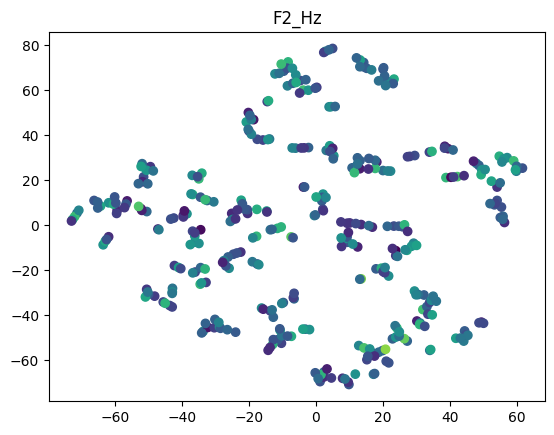

In [13]:
col = color_keys[-4]
plt.scatter( X_embedded[:,0], X_embedded[:,1], c=cv_np[col] )
plt.title(col)